In [5]:
import numpy as np
import os

folder_path = '/tf/rahman/Niccolo/'


npy_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.npy')]


arrays = [np.load(file) for file in npy_files]

In [21]:
ECG=np.asarray(arrays)

In [ ]:
import numpy as np
import wfdb
from wfdb import processing
from scipy.signal import butter, filtfilt, correlate, correlation_lags
from custom_dataset import FinalDataset
# Constants
Fs = 400  # Sampling frequency
i_left = int(20e-3 * Fs)
i_right = int(50e-3 * Fs)
pq = int(0.08 * Fs)
qt = int(0.10 * Fs)
max_lag = 0.9

# Bandpass filter function
def filter_signal(ecg, fs):
    b, a = butter(3, [0.5 * 2 / fs, 40 * 2 / fs], btype='bandpass')
    return filtfilt(b, a, ecg, axis=0)


def woody(ecg, q_indices, i_left, i_right):
    vm = np.sqrt(np.sum(ecg**2, axis=1))
    segment_len = i_left + i_right
    beats = []

    for q in q_indices:
        start = q - i_left
        end = q + i_right
        
        # Skip if segment would be out of bounds
        if start < 0 or end > len(vm):
            continue
        
        segment = vm[start:end]
        
        if len(segment) == segment_len:
            beats.append(segment)

    if len(beats) == 0:
        return q_indices  

    beats = np.array(beats)

    template = np.nanmean(beats, axis=0)
    correlations = np.array([correlate(template, beat, mode="full") for beat in beats])
    lags = correlation_lags(template.size, segment_len, mode="full")
    delays = lags[np.argmax(correlations, axis=1)]

    corrected_q_indices = []

    valid_indices = 0
    for delay, q in zip(delays, q_indices):
        start = q - i_left
        end = q + i_right
        if start < 0 or end > len(vm):
            continue
        if delay < 0:
            corrected_q_indices.append(q + abs(delay))
        else:
            corrected_q_indices.append(q - delay)

    return np.array(corrected_q_indices)


def process_ecg(ecg_data, fs):
    results = []
    for idx, (ecg,label) in enumerate(ecg_data):
        if idx % 1000 == 0:
            print(f"Processing instance {idx}")
        # convert from tensor to numpy array
        ecg = ecg.numpy()
        
        #ecg_filtered = filter_signal(ecg, fs)
        qrs_inds = processing.gqrs_detect(ecg[:, 0], fs=fs)
        #print(qrs_inds)
        
        if qrs_inds.size > 0:
            corrected_peaks = processing.peaks.correct_peaks(
                ecg[:, 0], peak_inds=qrs_inds,
                search_radius=int(fs * 90 / 230), smooth_window_size=130
            )
            q_corrected = woody(ecg, corrected_peaks, i_left, i_right)
            leads = ecg.shape[1]
            avg_beat = np.full((leads, pq + qt), np.nan)

            for lead in range(leads):
                beats = np.full((len(q_corrected), pq + qt), np.nan)
                for i, q in enumerate(q_corrected):
                    start = max(0, q - pq)
                    end = min(len(ecg), q + qt)
                    beat = ecg[start:end, lead]
                    beats[i, :len(beat)] = beat
                avg_beat[lead, :] = np.nanmean(beats, axis=0) if not np.all(np.isnan(beats)) else np.nan

            results.append((avg_beat,label))
        else:
            print(f"No QRS detected for instance {idx}")
            results.append(None)
    return results


dataset = FinalDataset("./data/Dataset.hdf5")
average_beats = process_ecg(dataset, Fs)


Processing instance 0
Processing instance 1000
No QRS detected for instance 1362
Processing instance 2000
No QRS detected for instance 2300
No QRS detected for instance 2625
No QRS detected for instance 2885
Processing instance 3000
No QRS detected for instance 3010
Processing instance 4000
No QRS detected for instance 4728
Processing instance 5000
No QRS detected for instance 5498
Processing instance 6000
No QRS detected for instance 6153
No QRS detected for instance 6184
No QRS detected for instance 6272
No QRS detected for instance 6552
Processing instance 7000
No QRS detected for instance 7126
No QRS detected for instance 7155
No QRS detected for instance 7458
No QRS detected for instance 7662
Processing instance 8000
No QRS detected for instance 8726
No QRS detected for instance 8949
Processing instance 9000
No QRS detected for instance 9045
No QRS detected for instance 9110
Processing instance 10000
No QRS detected for instance 10590
No QRS detected for instance 10682
No QRS dete

In [17]:
len(average_beats)
print(average_beats[364807])
without_none = [x for x in average_beats if x is not None]
len(without_none)

None


365370

In [18]:
# Save the results
import h5py

with h5py.File('average_beats.hdf5', 'w') as f:
    # i want one dataset for beats and one for labels
    beats_dataset = f.create_dataset('beats', data=np.array([x[0] for x in without_none]))
    labels_dataset = f.create_dataset('labels', data=np.array([x[1] for x in without_none]))
    

Matplotlib created a temporary cache directory at /tmp/matplotlib-24sxlugx because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


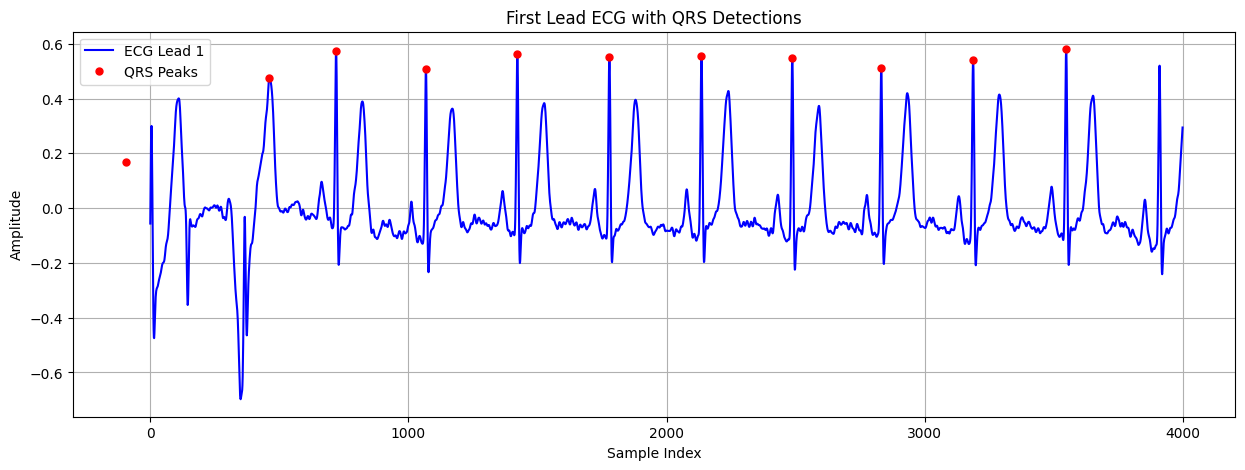

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import wfdb
from wfdb import processing

# Plot the first ECG recording, first lead
first_ecg = ECG[0]          # Take the first ECG (shape: samples x leads)
first_lead = first_ecg[:, 0]  # Take the first lead (lead 0)

# Detect QRS on the first lead
qrs_inds = processing.gqrs_detect(first_lead, fs=Fs)

# Correct the QRS peaks
corrected_qrs = processing.peaks.correct_peaks(
    first_lead, peak_inds=qrs_inds,
    search_radius=int(Fs * 90 / 200), smooth_window_size=130
)

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(first_lead, label='ECG Lead 1', color='b')
plt.plot(corrected_qrs, first_lead[corrected_qrs], 'ro', markersize=5, label='QRS Peaks')

plt.title('First Lead ECG with QRS Detections')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


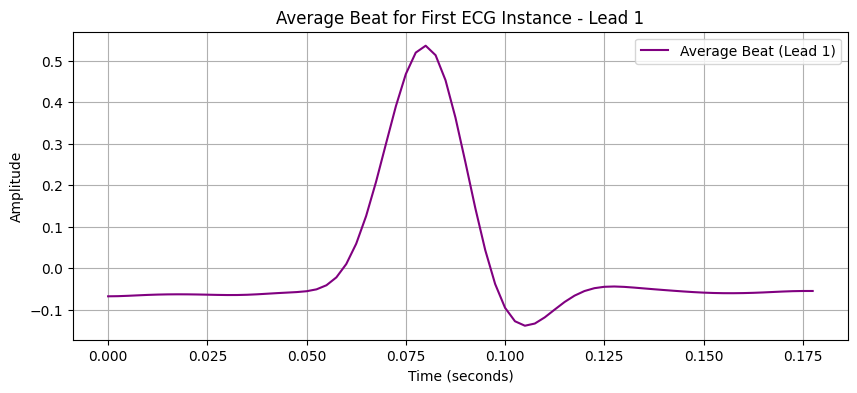

In [19]:
import matplotlib.pyplot as plt
import numpy as np


avg_beat_instance = average_beats[0]  
first_lead_avg_beat = avg_beat_instance[0, :]  

time_axis = np.arange(len(first_lead_avg_beat)) / Fs  # Fs = 400 Hz

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(time_axis, first_lead_avg_beat, color='purple', label='Average Beat (Lead 1)')
plt.title('Average Beat for First ECG Instance - Lead 1')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()


In [2]:
from custom_dataset import BeatsDataset

beats_dataset = BeatsDataset("./data/average_beats.hdf5")
for i in range(5):
    ecg, label = beats_dataset[i]
    print(f"Label: {label}")
    print(f"ECG shape: {ecg.shape}")
    print(ecg)
    print()

Label: tensor([0.])
ECG shape: torch.Size([12, 72])
tensor([[-0.0936, -0.0945, -0.0964, -0.0996, -0.1038, -0.1088, -0.1140, -0.1188,
         -0.1228, -0.1255, -0.1267, -0.1265, -0.1247, -0.1212, -0.1159, -0.1082,
         -0.0981, -0.0851, -0.0692, -0.0498, -0.0257,  0.0052,  0.0461,  0.1009,
          0.1735,  0.2667,  0.3806,  0.5112,  0.6501,  0.7842,  0.8981,  0.9764,
          1.0067,  0.9829,  0.9065,  0.7861,  0.6361,  0.4738,  0.3157,  0.1751,
          0.0604, -0.0253, -0.0835, -0.1184, -0.1360, -0.1421, -0.1418, -0.1389,
         -0.1359, -0.1341, -0.1337, -0.1347, -0.1363, -0.1380, -0.1393, -0.1402,
         -0.1406, -0.1408, -0.1410, -0.1414, -0.1420, -0.1428, -0.1434, -0.1435,
         -0.1429, -0.1413, -0.1389, -0.1358, -0.1326, -0.1297, -0.1274, -0.1261],
        [-0.1422, -0.1461, -0.1501, -0.1543, -0.1584, -0.1622, -0.1655, -0.1681,
         -0.1697, -0.1706, -0.1711, -0.1723, -0.1753, -0.1812, -0.1905, -0.2030,
         -0.2167, -0.2285, -0.2338, -0.2269, -0.2022, -0